# 04b Multiple Linear regression model trained on good IMD regions 

> k-fold cross validation of regression model choice   

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

### Load the Autonomy style bits 

In [6]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [7]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [8]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,186.084815,0.122844
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,124.734713,0.131269
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,442.084950,0.358794
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,78.032656,0.114776


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [9]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc', 
             'GP_LAD_pc']

covar_opt_noGP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [10]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [11]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-55]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Aylesbury Vale',
 'Wycombe',
 'South Northamptonshire',
 'Chiltern',
 'South Bucks']

In [12]:
len(df_dem_topIMD)

50

In [13]:
print(least_50_IMD)

['York', 'Rutland', 'Bath and North East Somerset', 'South Gloucestershire', 'Bracknell Forest', 'West Berkshire', 'Windsor and Maidenhead', 'Wokingham', 'Central Bedfordshire', 'Aylesbury Vale', 'Chiltern', 'South Bucks', 'Wycombe', 'East Cambridgeshire', 'South Cambridgeshire', 'Derbyshire Dales', 'Brentwood', 'Rochford', 'Uttlesford', 'Cotswold', 'Stroud', 'East Hampshire', 'Eastleigh', 'Fareham', 'Hart', 'Winchester', 'North Hertfordshire', 'Three Rivers', 'Tunbridge Wells', 'Ribble Valley', 'Blaby', 'Harborough', 'North Kesteven', 'South Northamptonshire', 'Harrogate', 'Rushcliffe', 'South Oxfordshire', 'Vale of White Horse', 'West Oxfordshire', 'Elmbridge', 'Epsom and Ewell', 'Guildford', 'Mole Valley', 'Reigate and Banstead', 'Surrey Heath', 'Waverley', 'Woking', 'Warwick', 'Horsham', 'Mid Sussex', 'Bromsgrove', 'St Albans', 'East Hertfordshire', 'Kingston upon Thames', 'Richmond upon Thames']


2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

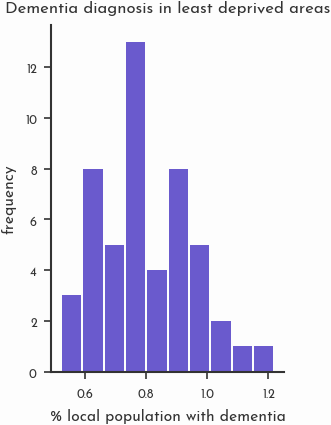

In [14]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

## All possible covariates 
What happens if I include all possible covariates?

In [15]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [16]:
# Linear regression using sklearn 

x_IMD_train = df_dem_topIMD[covar_opt].values.reshape(-1,len(covar_opt))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_IMD_train, y_IMD_train)
y_pred_all = regr.predict(x_test_all)

In [17]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.19478811349795777
-------- 
 coefficients of independent variables 
 
over_65_pc:0.018372793673372224 

female_pc:0.01008168207634275 

ALevel_plus_pc:-0.007691932159444685 

white_pc:-0.005768498145060164 

HYP_afflicted_pc:0.011062302519558646 

DM_afflicted_pc:-0.037166675323985585 

STIA_afflicted_pc:0.26160411966157276 

GP_LAD_pc:-0.07223271795453191 



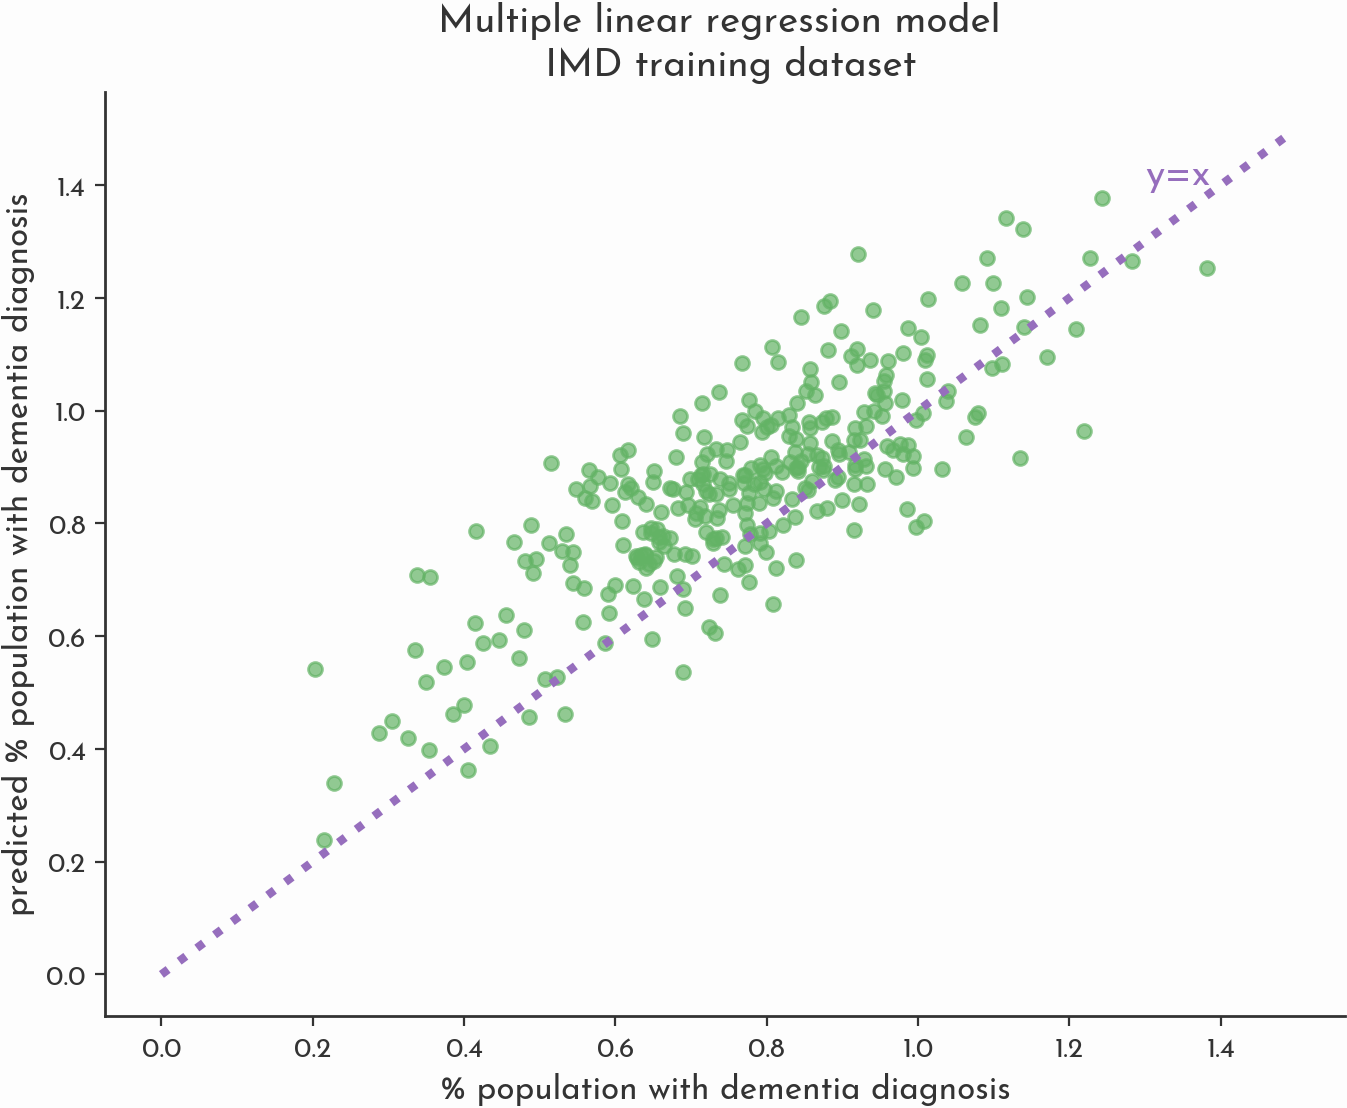

In [18]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y_test_all, y_pred_all, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model \n IMD training dataset', fontsize=14)
plt.text(1.3, 1.4, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/IMD_linear_reg_scatter_plt.png')
plt.show()

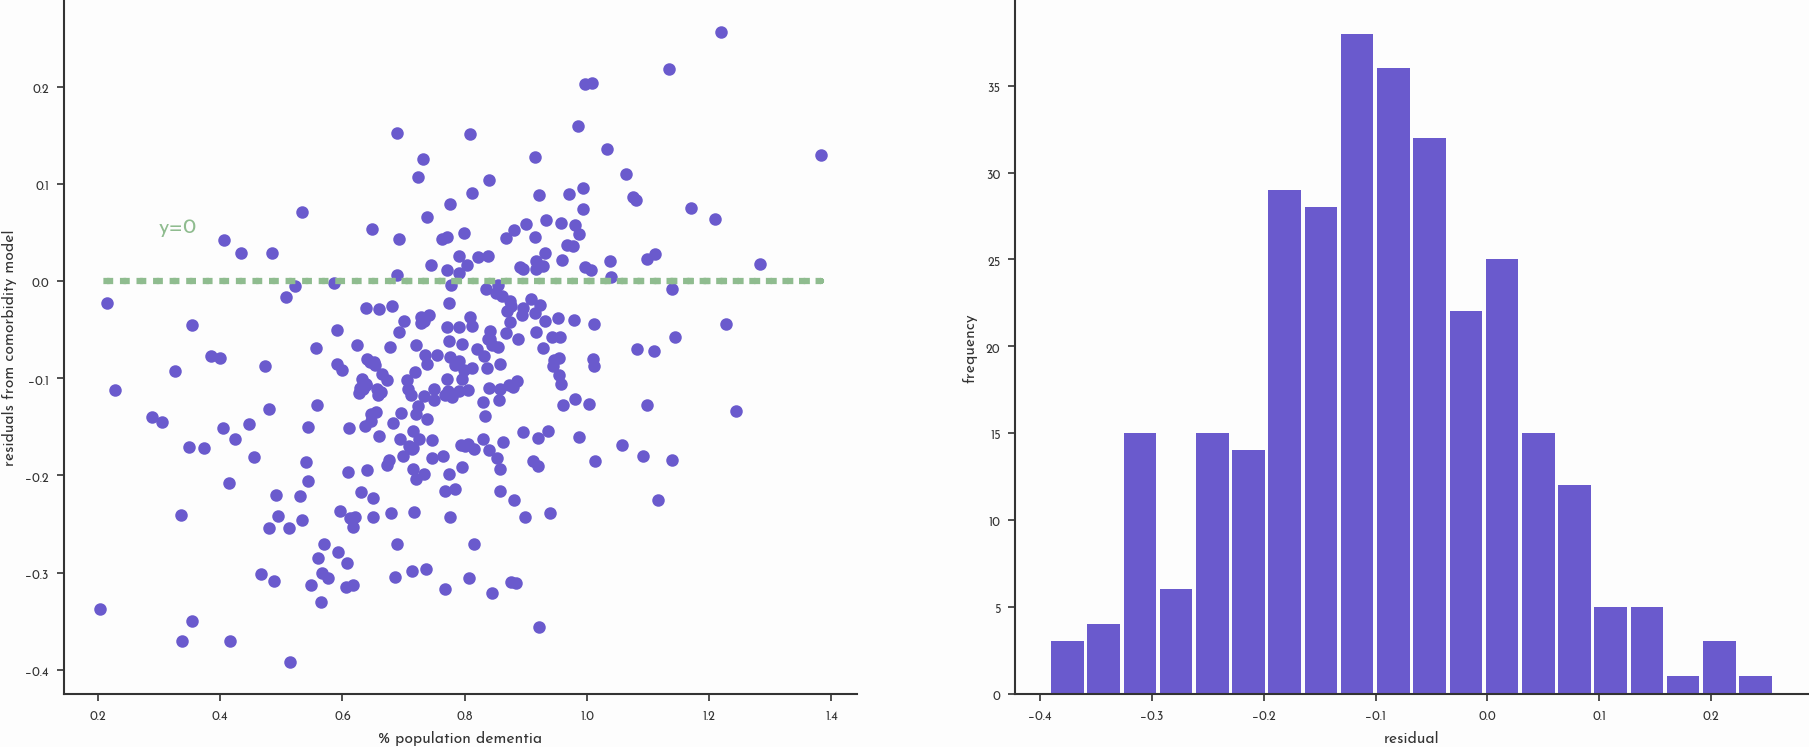

In [19]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y_test_all-y_pred_all)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

And the same again, but leaving out the GP density covariate 

In [20]:
# Linear regression using sklearn 

x_IMD_train_noGP = df_dem_topIMD[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_noGP = df_dem_plus[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_noGP = linear_model.LinearRegression()

# fit regression comorbidities
regr_noGP.fit(x_IMD_train_noGP, y_IMD_train)
y_pred_all_noGP = regr_noGP.predict(x_test_all_noGP)

print(f'intercept:{regr_noGP.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_noGP):
    print(f'{covar}:{regr_noGP.coef_[0][i]} \n')

intercept:0.18419026338016153
-------- 
 coefficients of independent variables 
 
over_65_pc:0.017428298907625088 

female_pc:0.009950096140691643 

ALevel_plus_pc:-0.007727855082455958 

white_pc:-0.005695058355915247 

HYP_afflicted_pc:0.01249053602091118 

DM_afflicted_pc:-0.03945308916430315 

STIA_afflicted_pc:0.27107258090739056 



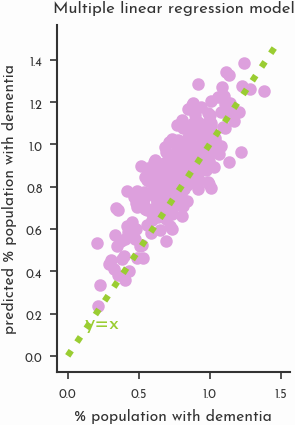

In [21]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all_noGP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

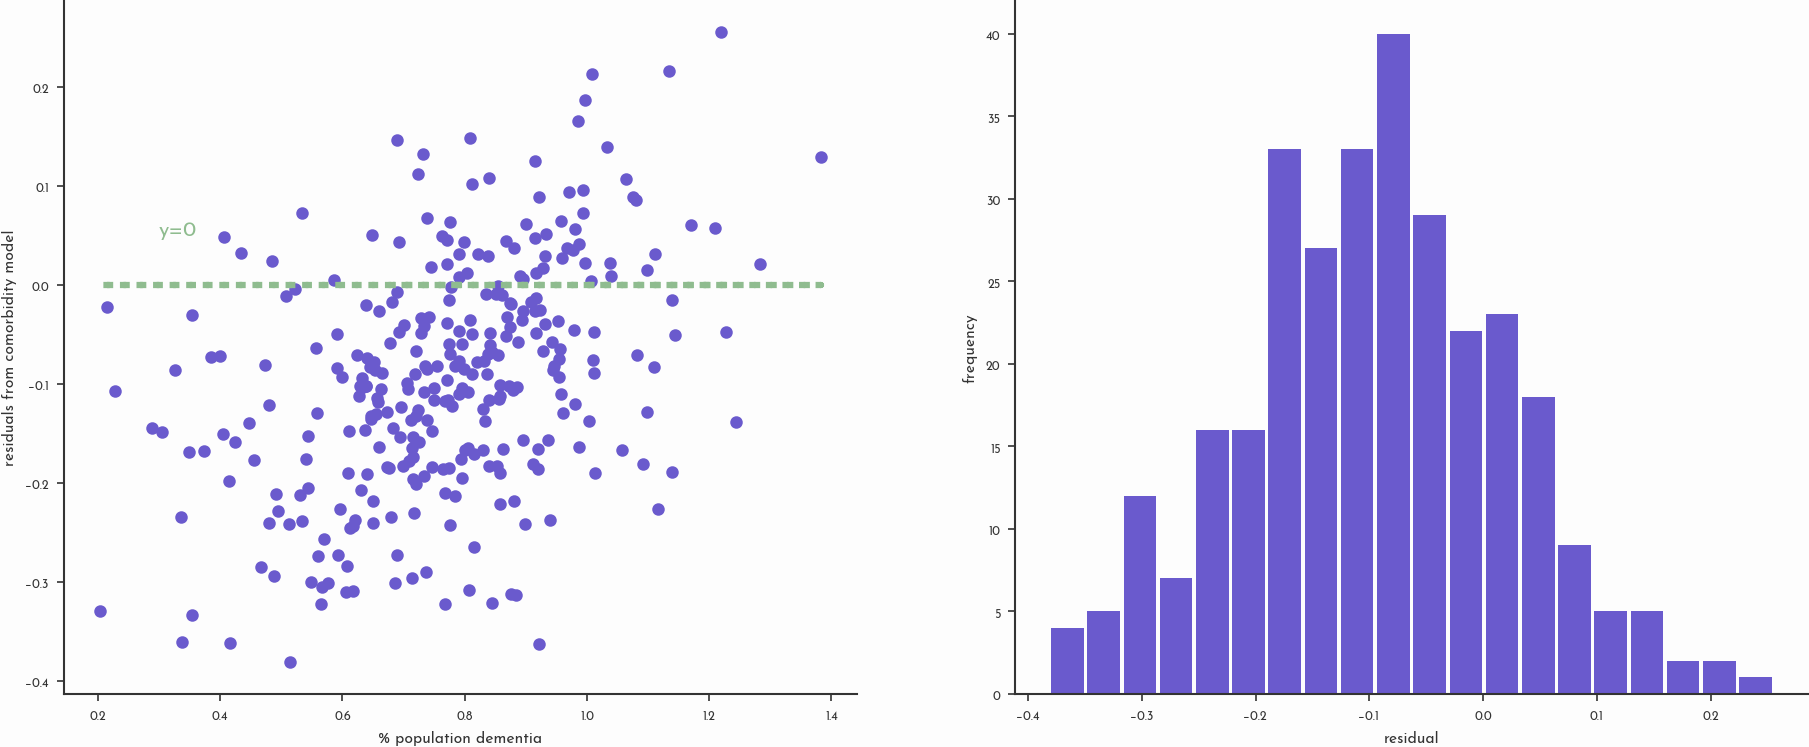

In [22]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals_noGP = (y_test_all-y_pred_all_noGP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals_noGP, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_noGP, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the regression model to a .csv 

In [23]:
# add columns of results to the dataframe 
df_dem_plus['IMD_reg_model_residuals'] = residuals
df_dem_plus['IMD_reg_model_pred'] = y_pred_all

df_dem_plus['IMD_reg_model_noGP_residuals'] = residuals_noGP
df_dem_plus['IMD_reg_model_noGP_pred'] = y_pred_all_noGP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/IMD_reg_model_results.csv')

## Look at IMD rank of areas with large residuals

In [24]:
# Areas residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.3]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

12                           Pendle
21             Barking and Dagenham
39            Blackburn with Darwen
40                       South Hams
73                           Slough
75                         Redditch
90                       Birmingham
107                        Cornwall
122    King's Lynn and West Norfolk
132                          Ealing
134                     Scarborough
163                           Luton
197                        Sandwell
212                      Broxbourne
253                        Basildon
271                            Eden
284                          Newham
286                        Torridge
290                           Brent
294           Nuneaton and Bedworth
Name: area_name, dtype: object


In [25]:
residuals[40]

array([-0.30547535])

In [26]:
df_dem_plus[df_dem_plus['area_name']=='South Hams']

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred
40,E07000044,South Hams,74072,597.62437,12201.179619,4036.440908,1928.689732,42560.0,46217.5554,42993.9842,...,62.395447,16.472054,5.449348,2.603804,133.272272,0.179923,-0.305475,1.112291,-0.30806,1.114875


In [27]:
worst_5_resid = np.argsort(np.array(residuals.reshape(309)))[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name']+covar_opt]

,area_name,over_65_pc,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
10,Southend-on-Sea,23.600073,63.109901,44.333027,81.6,15.104013,5.784186,1.922887,0.137461
102,Colchester,21.530152,61.296004,50.439987,80.7,13.583193,4.800804,1.591681,0.102179
76,Exeter,19.385510,58.745747,58.965291,82.7,12.835116,5.220333,1.763662,0.066383
119,Harrogate,28.871180,62.810418,57.045926,90.7,15.806634,5.160332,2.240924,0.165944
289,Lincoln,18.124966,61.697292,54.075785,82.7,11.432470,4.744160,1.545944,0.071612
159,Rushcliffe,26.156822,61.437173,61.366935,86.1,13.192616,4.785857,1.947610,0.212437
29,East Devon,36.652563,63.256897,52.088405,94.2,18.398179,6.787375,2.868139,0.141865
272,Gosport,25.530861,60.593137,43.336177,92.5,16.899720,7.549057,2.248049,0.073366
225,Southampton,16.705164,59.824464,51.816027,68.1,11.039538,5.131145,1.630277,0.201805
248,Guildford,20.409057,58.736111,61.339131,77.3,11.853822,4.275616,1.304893,0.287693


In [28]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
7,E06000008,Blackburn with Darwen,23819.60,14,36.013,9,0.3626,9,0.5519,7,32396.85,18
29,E06000032,Luton,20864.04,52,25.908,70,0.0331,145,0.2710,72,29512.26,122
36,E06000039,Slough,19788.26,73,22.965,103,0.0000,195,0.1122,152,27534.97,172
48,E06000052,Cornwall,19382.41,83,23.072,101,0.0521,121,0.1323,141,29411.09,123
69,E07000030,Eden,14688.07,169,16.328,186,0.0000,195,0.0046,280,22163.56,262
83,E07000044,South Hams,12057.07,219,13.724,229,0.0000,195,0.0012,289,20908.71,276
85,E07000046,Torridge,20086.96,67,23.269,99,0.0000,195,0.1025,160,27564.45,171
92,E07000066,Basildon,17744.60,111,23.243,100,0.1091,80,0.2623,76,30503.62,94
121,E07000095,Broxbourne,15414.09,153,17.989,164,0.0000,195,0.0705,180,26744.49,185
144,E07000122,Pendle,21934.23,36,30.723,33,0.3158,14,0.4077,29,31652.21,55


In [29]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [30]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [31]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,19.073111,6.164929,2.948652,186.084815,0.122844,-0.044003,1.270920,-0.048140,1.275057,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,10.372597,3.650571,1.287952,437.450820,0.278995,0.053284,0.594864,0.050580,0.597568,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,13.584680,4.848008,1.987987,124.734713,0.131269,0.088425,0.833735,0.088877,0.833283,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,13.640026,5.506448,2.148768,442.084950,0.358794,0.202954,0.793992,0.186209,0.810737,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,15.965501,6.298085,2.250735,78.032656,0.114776,-0.168092,0.973825,-0.164550,0.970283,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,13.291837,5.650779,1.602052,184.238057,0.222185,-0.036890,0.845241,-0.035312,0.843663,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,17.399056,6.822075,2.356606,392.005902,0.171345,-0.168560,0.962154,-0.175745,0.969340,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,15.234047,5.791747,2.049750,262.879898,0.093249,-0.122022,0.872279,-0.116670,0.866927,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,14.819090,4.788832,2.072753,136.391104,0.188999,0.057833,0.922950,0.056314,0.924469,294


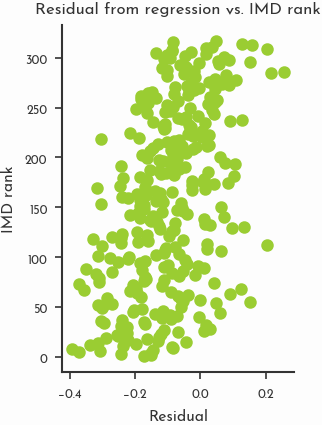

In [32]:
plt.scatter(df_dem_plus_IMD['IMD_reg_model_residuals'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [33]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

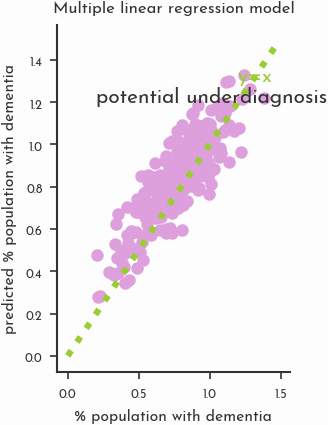

In [34]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [35]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.11036980714385047
-------- 
 coefficients of independent variables 
 
over_65_pc:0.023312789693122043 

female_pc:0.006887464007860241 

ALevel_plus_pc:-0.005872489298108126 

white_pc:-0.003963738999451919 

HYP_afflicted_pc:0.018156338587656553 

DM_afflicted_pc:-0.024934189362012346 

STIA_afflicted_pc:0.11850780632249644 

GP_LAD_pc:-0.029158856010753863 



In [36]:
np.dot(np.array(x_test_all_covar), regr.coef_[0]) + regr.intercept_[0]

array([1.21250189, 0.59459126, 0.79564452, 0.76706374, 0.96647741,
       0.72153127, 0.82619217, 0.85693354, 0.91877318, 0.8023079 ,
       0.86531275, 0.86400932, 0.91968041, 1.08724894, 0.94361618,
       0.90512552, 1.05579684, 0.81267092, 0.86420238, 0.90251896,
       0.67840812, 0.62574118, 0.79095896, 0.88679019, 1.06048575,
       0.96130323, 0.81544296, 0.99998873, 0.90792158, 1.22181619,
       0.87908515, 1.18287384, 0.41705282, 0.98318851, 0.80994953,
       1.16256798, 0.87082559, 0.74337243, 1.06069845, 0.83608069,
       1.09008731, 0.38064629, 0.53653983, 0.66240446, 0.86769419,
       0.82378982, 0.73965008, 0.95087823, 0.48526114, 0.90611371,
       0.93870657, 0.58631283, 0.73627398, 0.74216737, 0.79380105,
       0.91585494, 1.19288593, 0.69738454, 0.68063979, 1.02259597,
       0.73933116, 1.0612195 , 0.28361263, 1.07610339, 0.858349  ,
       0.65582079, 0.97274552, 0.80992342, 0.83085341, 0.68687291,
       0.68178728, 1.04294803, 0.89801943, 0.70353024, 1.18249

### Lasso regression 

In [37]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

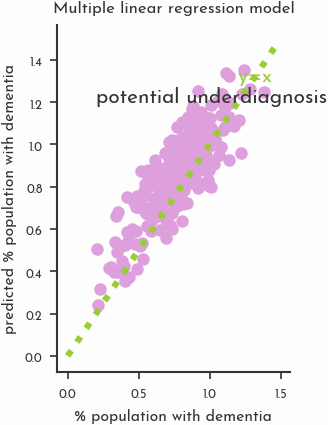

In [38]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [39]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.043221998613001134
-------- 
 coefficients of independent variables 
 
over_65_pc:0.019770539206531053 

female_pc:0.008726911416884215 

ALevel_plus_pc:-0.006159753969154459 

white_pc:-0.004265578650915954 

HYP_afflicted_pc:0.009720582628277264 

DM_afflicted_pc:-0.019016975369083606 

STIA_afflicted_pc:0.20915019414293812 

GP_LAD_pc:-0.0 



## Alternative using the GP density to select the training set 

In [40]:
# the 50 least deprived LADs according to the IMD
GP_vals = df_dem_plus['GP_LAD_pc'].values

df_highest_GP_50 = df_dem_plus.iloc[GP_vals.argsort()[-50:]]

# let's check this dataset 
df_highest_GP_50.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred
293,E07000207,Elmbridge,106578,793.043976,12241.934021,4095.114950,1613.911144,71488.0,71986.4337,67324.6442,...,67.543427,11.486361,3.842364,1.514300,216.889319,0.203503,0.016076,0.728022,0.017975,0.726123
101,E07000178,Oxford,124591,479.991181,9858.247645,4126.889686,1268.834016,93825.0,81271.8958,78442.7752,...,65.230952,7.912488,3.312350,1.018399,253.879066,0.203770,-0.077295,0.462549,-0.072937,0.458190
125,E07000194,Lichfield,87623,761.954449,14282.989024,5531.492554,1800.868206,45030.0,54224.1480,52626.6288,...,61.883464,16.300502,6.312832,2.055246,182.138652,0.207866,-0.030914,0.900497,-0.032673,0.902255
121,E09000003,Barnet,313694,2003.601221,35603.290480,16529.815112,4024.409402,190183.0,200300.8367,187905.7585,...,63.852301,11.349688,5.269407,1.282909,660.248227,0.210475,-0.105886,0.744598,-0.101857,0.740569
253,E07000066,Basildon,147650,836.308895,21230.763939,8435.195025,2707.627275,61857.0,96431.9056,91197.3989,...,65.311145,14.379115,5.712966,1.833815,312.348745,0.211547,-0.300268,0.866681,-0.305253,0.871666


In [41]:
# Potential covariates 
covar_opt_no_GP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

In [42]:
# Linear regression using sklearn 

x_GP_train = df_highest_GP_50[covar_opt_no_GP].values.reshape(-1,len(covar_opt_no_GP))
y_GP_train = df_highest_GP_50['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt_no_GP].values.reshape(-1,len(covar_opt_no_GP))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_GP_train, y_GP_train)
y_pred_all_GP = regr.predict(x_test_all)

In [43]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_no_GP):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.06976161697913308
-------- 
 coefficients of independent variables 
 
over_65_pc:0.021216327593908204 

female_pc:0.0027844439237098913 

ALevel_plus_pc:-0.0025997681155234286 

white_pc:-0.002434129158481422 

HYP_afflicted_pc:0.011464589960104823 

DM_afflicted_pc:-0.02593256161799395 

STIA_afflicted_pc:0.17845594423156588 



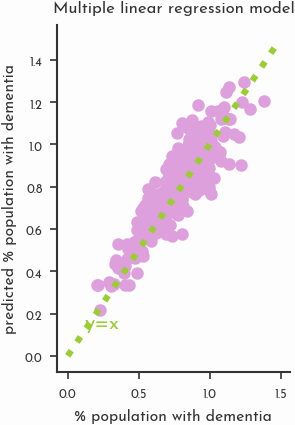

In [44]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all_GP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

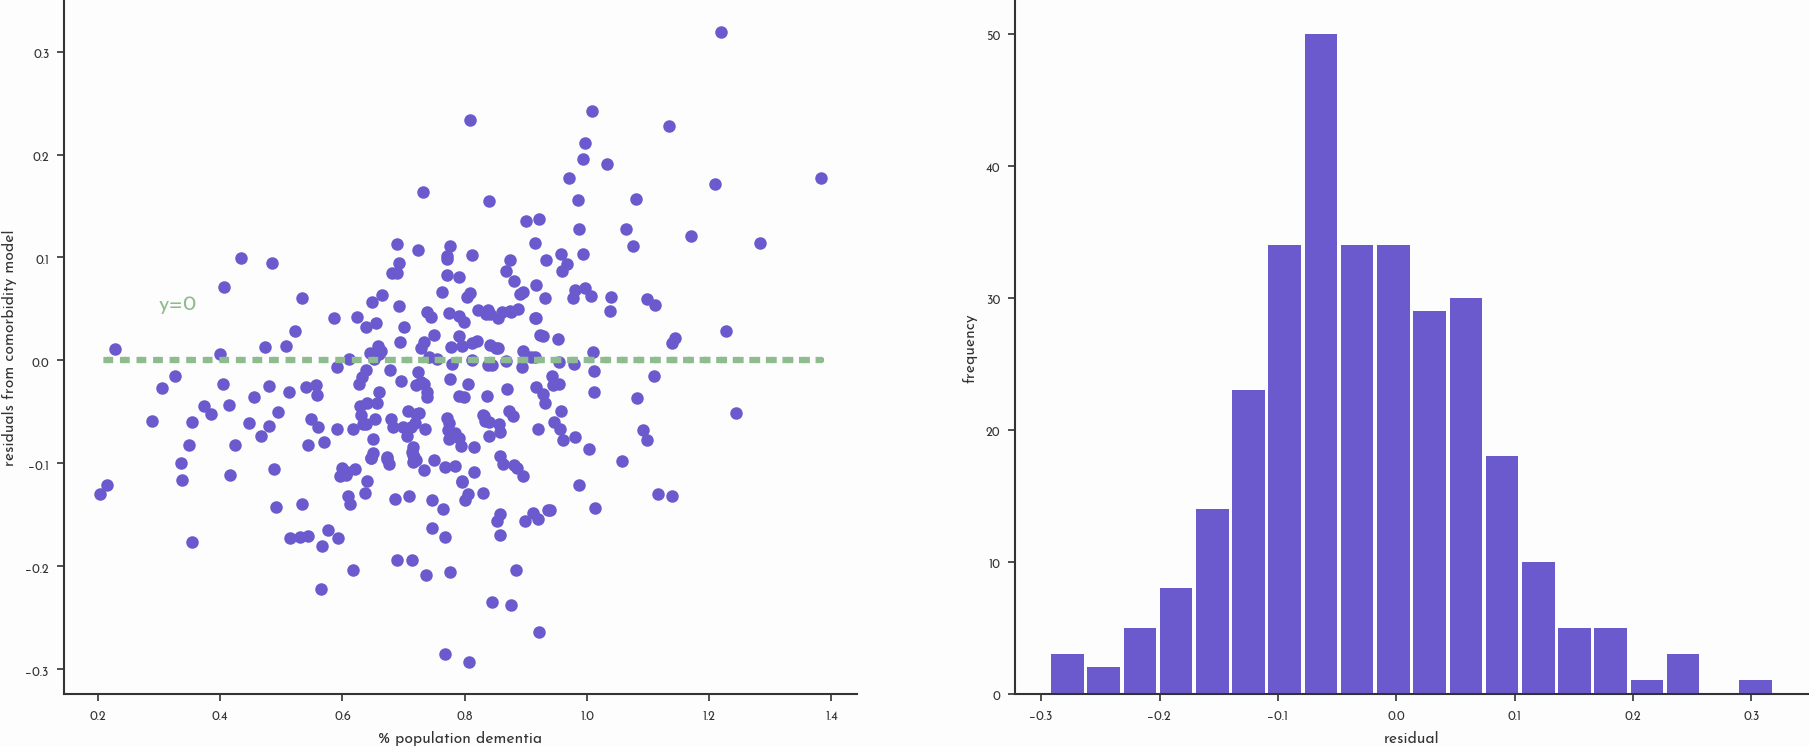

In [45]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

GP_residuals = (y_test_all-y_pred_all_GP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, GP_residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(GP_residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

In [46]:
# add columns of results to the dataframe 
df_dem_plus['GP_reg_model_residuals'] = GP_residuals
df_dem_plus['GP_reg_model_pred'] = y_pred_all_GP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/GP_reg_model_results.csv')